In [1]:
import torch
import copy
import random
import matplotlib.pyplot as plt

torch.set_grad_enabled(False)

from safetensors.torch import load_file
from diffusers import DiffusionPipeline

/share/u/rohit/.conda/envs/visdiff/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/share/u/rohit/.conda/envs/visdiff/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


In [5]:
torch_dtype = torch.bfloat16
device = 'cuda:0'
uce_path = '/share/u/rohit/unified-concept-editing/uce_models/rich_debias_sdxl.safetensors'

pipe = DiffusionPipeline.from_pretrained(
                                         # "CompVis/stable-diffusion-v1-4", 
                                         "stabilityai/stable-diffusion-xl-base-1.0",
                                         torch_dtype=torch_dtype, 
                                         safety_checker=None).to(device)

uce_weights = load_file(uce_path)
original_weights = {}
for name, param in pipe.unet.named_modules():
    if name+'.weight' in uce_weights:
        original_weights[name+'.weight'] = copy.deepcopy(param.weight)

Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
def display_grids(og_images, uce_images):
    import matplotlib.pyplot as plt
    # Create figure
    fig = plt.figure(figsize=(14, 8))
    
    # Create two separate GridSpec objects for each 3x3 grid with different positions
    grid1 = plt.GridSpec(3, 3, wspace=0, hspace=0, left=0.05, right=0.45)
    grid2 = plt.GridSpec(3, 3, wspace=0, hspace=0, left=0.55, right=0.95)
    
    # Add title for the first grid
    fig.text(0.25, 0.95, "Original Model", fontsize=16, ha='center')
    
    # Add title for the second grid
    fig.text(0.75, 0.95, "UCE Model", fontsize=16, ha='center')
    
    # Plot first grid of images
    for i in range(9):
        row, col = i // 3, i % 3
        ax = plt.subplot(grid1[row, col])
        ax.imshow(og_images[i])
        ax.axis('off')
    
    # Plot second grid of images
    for i in range(9):
        row, col = i // 3, i % 3
        ax = plt.subplot(grid2[row, col])
        ax.imshow(uce_images[i])
        ax.axis('off')
    
    plt.show()

Loaded original model weights


  0%|          | 0/50 [00:00<?, ?it/s]

Loaded UCE model weights


  0%|          | 0/50 [00:00<?, ?it/s]

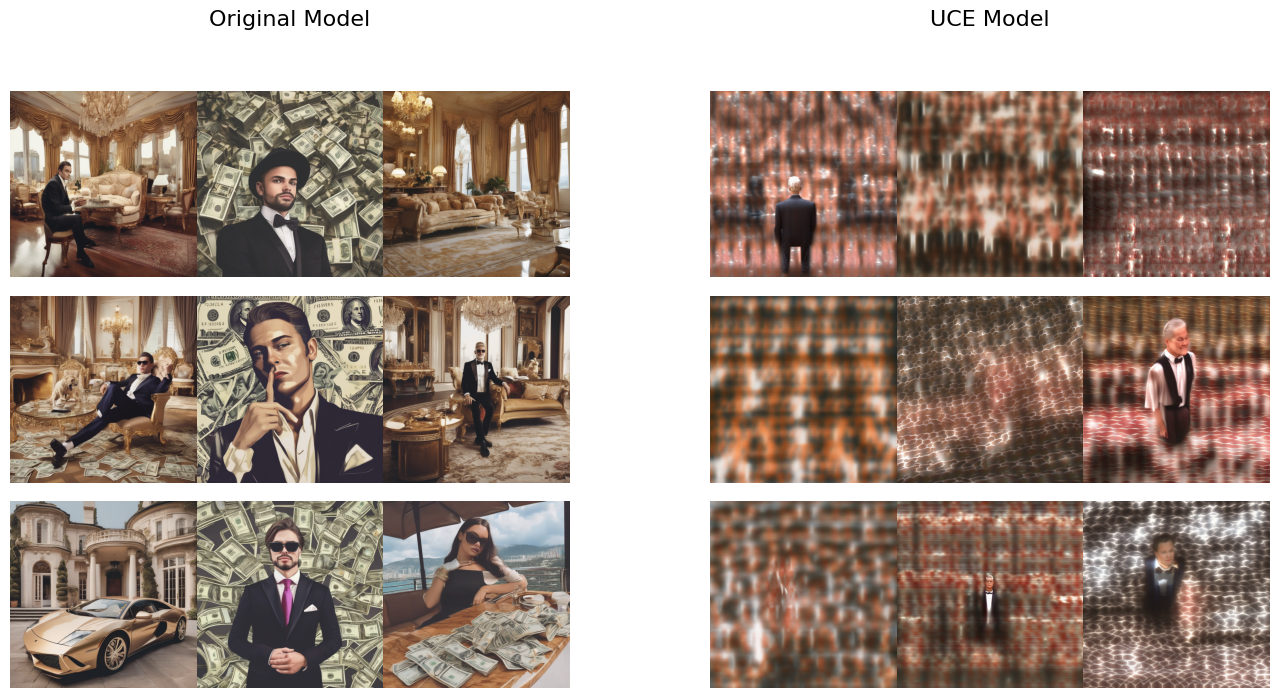

In [7]:
seed = random.randint(0, 2**15)
prompt = 'picture of a rich person'
# Load original model weights
pipe.unet.load_state_dict(original_weights, strict=False)
print('Loaded original model weights')
# concept to be erased
og_images = pipe(prompt,
                    guidance_scale = 7.5, 
                    num_inference_steps=50,
                 num_images_per_prompt=9,
                    generator=torch.Generator().manual_seed(seed)
                   ).images

pipe.unet.load_state_dict(uce_weights, strict=False)
print('Loaded UCE model weights')
# concept to be preserved
uce_images = pipe(prompt,
                    guidance_scale = 7.5, 
                    num_inference_steps=50,
                 num_images_per_prompt=9,
                    generator=torch.Generator().manual_seed(seed)
                   ).images


display_grids(og_images, uce_images)

# Run original model

Loaded original model weights


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Original Model')

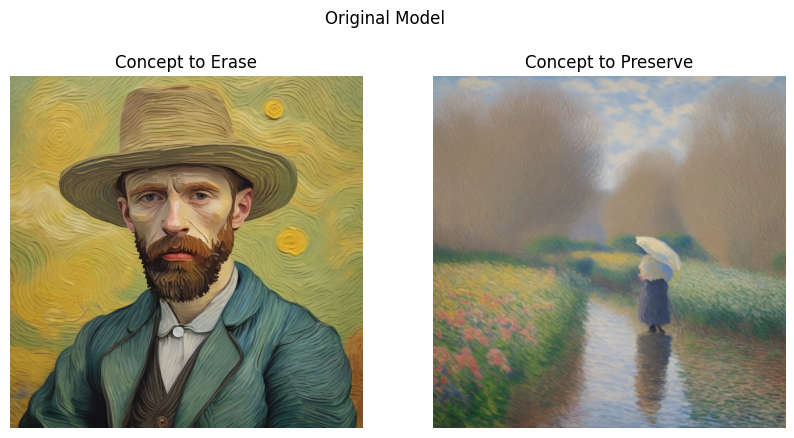

In [6]:
seed = random.randint(0, 2**15)
prompt_of_erased_concept = 'artwork of a person in the style of Van Gogh'
prompt_of_other_concept = 'artwork of a person in the style of Claude Monet'
# Load original model weights
pipe.unet.load_state_dict(original_weights, strict=False)
print('Loaded original model weights')
# concept to be erased
erased_image = pipe(prompt_of_erased_concept,
                    guidance_scale = 7.5, 
                    num_inference_steps=50,
                    generator=torch.Generator().manual_seed(seed)
                   ).images[0]
# concept to be preserved
preserved_image = pipe(prompt_of_other_concept,
                    guidance_scale = 7.5, 
                    num_inference_steps=50,
                    generator=torch.Generator().manual_seed(seed)
                   ).images[0]


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(erased_image)
axs[0].axis('off')
axs[0].set_title('Concept to Erase')

axs[1].imshow(preserved_image)
axs[1].axis('off')
axs[1].set_title('Concept to Preserve')
fig.suptitle('Original Model')

# Run UCE model

Loaded UCE model weights


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 0.98, 'UCE Model')

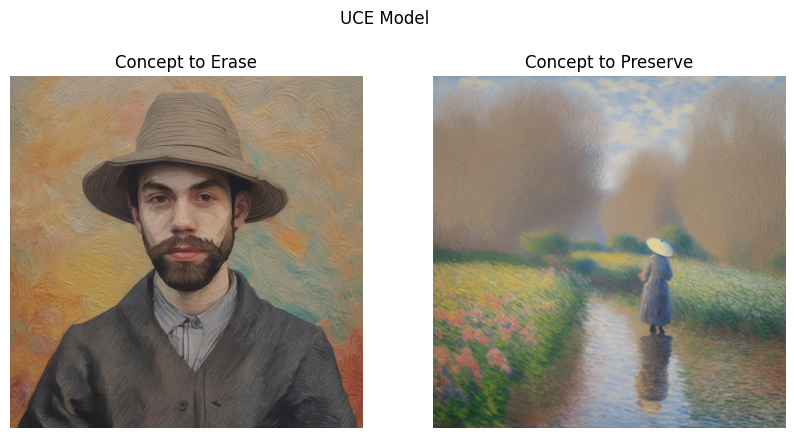

In [7]:
# Load UCE model weights
pipe.unet.load_state_dict(uce_weights, strict=False)
print('Loaded UCE model weights')
# concept to be erased
erased_image = pipe(prompt_of_erased_concept,
                    guidance_scale = 7.5, 
                    num_inference_steps=50,
                    generator=torch.Generator().manual_seed(seed)
                   ).images[0]
# concept to be preserved
preserved_image = pipe(prompt_of_other_concept,
                    guidance_scale = 7.5, 
                    num_inference_steps=50,
                    generator=torch.Generator().manual_seed(seed)
                   ).images[0]


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(erased_image)
axs[0].axis('off')
axs[0].set_title('Concept to Erase')

axs[1].imshow(preserved_image)
axs[1].axis('off')
axs[1].set_title('Concept to Preserve')
fig.suptitle('UCE Model')